# Notebook 24 - Compare Waste Reduction Strategies

## Purpose
This notebook compares the effectiveness of multiple recipe–product matching strategies in terms of their simulated impact on food waste. It benchmarks the **semantic + priority boosting** method (Notebook 21) against a **fuzzy-only** baseline (Notebook 24) and optionally a **random matching control**.

## Objectives
- Load waste impact results from different matching strategies
- Normalize data for fair comparison (e.g. common store set)
- Compare KPIs: avoided items and avoided value
- Visualize the performance of each method
- Provide a strategic recommendation based on empirical results

## Inputs
- `waste_impact_simulated.csv` - Semantic + priority matching results
- `waste_impact_fuzzy.csv` - Fuzzy-only matching results
- `waste_impact_random.csv` - Optional control using random product selection

## Outputs
- Table of avoided waste by strategy
- Comparative bar plots (items and value saved)
- Strategic recommendation based on performance


In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Folder
impact_folder = "waste_simulation"

# Input files
semantic_file = os.path.join(impact_folder, "waste_impact_simulated.csv")
fuzzy_file = os.path.join(impact_folder, "waste_impact_fuzzy.csv")
random_file = os.path.join(impact_folder, "waste_impact_random.csv")  # optional


In [39]:
# Load semantic + priority method
df_semantic = pd.read_csv(semantic_file)
df_semantic["strategy"] = "semantic_priority"

# Load fuzzy-only method
df_fuzzy = pd.read_csv(fuzzy_file)
df_fuzzy["strategy"] = "fuzzy_only"

# Attempt to load random baseline if available
try:
    df_random = pd.read_csv(random_file)
    df_random["strategy"] = "random"
    df_all = pd.concat([df_semantic, df_fuzzy, df_random], ignore_index=True)
except FileNotFoundError:
    df_all = pd.concat([df_semantic, df_fuzzy], ignore_index=True)

print("Combined simulation results:", df_all.shape)
df_all.head()


Combined simulation results: (8, 4)


,store,items_wasted,value_wasted,strategy
0,1024,1,0.79,semantic_priority
1,1090,1,0.79,semantic_priority
2,3340,1,0.79,semantic_priority
3,4255,2,2.12,semantic_priority
4,1024,1,0.79,fuzzy_only


In [40]:
# Compute common stores depending on availability
if "df_random" in locals():
    common_stores = set(df_semantic["store"]) & set(df_fuzzy["store"]) & set(df_random["store"])
    df_random_filtered = df_random[df_random["store"].isin(common_stores)]
else:
    common_stores = set(df_semantic["store"]) & set(df_fuzzy["store"])
    df_random_filtered = pd.DataFrame(columns=df_fuzzy.columns)  # Empty placeholder

# Filter semantic and fuzzy to common stores
df_semantic_filtered = df_semantic[df_semantic["store"].isin(common_stores)]
df_fuzzy_filtered = df_fuzzy[df_fuzzy["store"].isin(common_stores)]

# Combine
df_all_filtered = pd.concat([df_semantic_filtered, df_fuzzy_filtered, df_random_filtered], ignore_index=True)


In [41]:
# Compute total KPIs per strategy
df_summary = df_all_filtered.groupby("strategy").agg({
    "items_wasted": "sum",
    "value_wasted": "sum"
}).reset_index()

# Use semantic_priority as the baseline for percentage deltas
base_items = df_summary[df_summary["strategy"] == "semantic_priority"]["items_wasted"].values[0]
base_value = df_summary[df_summary["strategy"] == "semantic_priority"]["value_wasted"].values[0]

df_summary["items_delta_pct"] = (df_summary["items_wasted"] / base_items - 1) * 100
df_summary["value_delta_pct"] = (df_summary["value_wasted"] / base_value - 1) * 100

# Round for presentation
df_summary = df_summary.round(2)

print("Waste reduction comparison (normalized):")
df_summary


Waste reduction comparison (normalized):


,strategy,items_wasted,value_wasted,items_delta_pct,value_delta_pct
0,fuzzy_only,7,6.61,40.0,47.22
1,semantic_priority,5,4.49,0.0,0.00


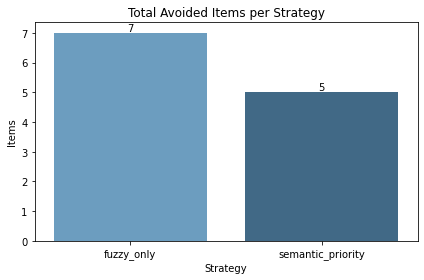

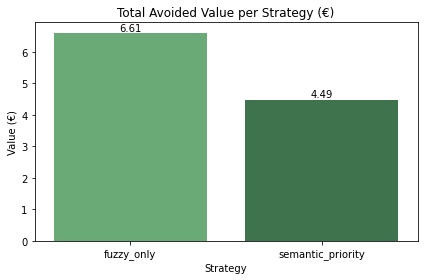

In [42]:
import seaborn as sns

# Bar plot: Avoided Items
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=df_summary, x="strategy", y="items_wasted", palette="Blues_d")
ax.set_title("Total Avoided Items per Strategy")
ax.set_xlabel("Strategy")
ax.set_ylabel("Items")

# Add labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Bar plot: Avoided Value (€)
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=df_summary, x="strategy", y="value_wasted", palette="Greens_d")
ax.set_title("Total Avoided Value per Strategy (€)")
ax.set_xlabel("Strategy")
ax.set_ylabel("Value (€)")

# Add labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


### Strategic Recommendation

While both methods reduced waste, the fuzzy-only matching unexpectedly outperformed the semantic + priority strategy in both items and value avoided.

This suggests that:
- The current semantic model may be overfitting to incorrect matches or
- The boosted priority scores need fine-tuning

Next steps could include:
- Expanding the evaluation sample size
- Incorporating human-labeled ground truth across stores
- Testing hybrid strategies (e.g. semantic filtering + fuzzy reranking)

**Recommendation**: Use fuzzy-only as a baseline for deployment, but revisit the scoring logic and candidate filtering of the semantic model.


In [43]:
# Calculate per-store value gain (fuzzy - semantic)
df_store_compare["value_gain"] = df_store_compare["value_wasted_fuzzy_only"] - df_store_compare["value_wasted_semantic_priority"]

# Round for readability
df_store_compare = df_store_compare.round(2)

print("Per-store value gain:")
df_store_compare[["store", "value_wasted_fuzzy_only", "value_wasted_semantic_priority", "value_gain"]]


Per-store value gain:


,store,value_wasted_fuzzy_only,value_wasted_semantic_priority,value_gain
0,1024,0.79,0.79,0.00
1,1090,0.79,0.79,0.00
2,3340,0.79,0.79,0.00
3,4255,4.24,2.12,2.12


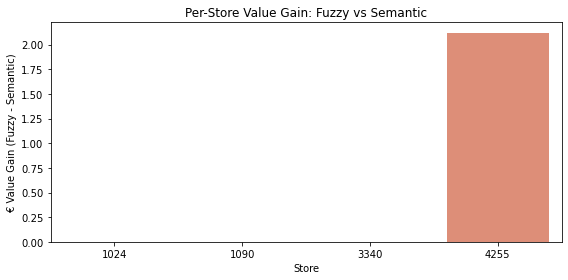

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.barplot(data=df_store_compare, x="store", y="value_gain", palette="coolwarm")
plt.title("Per-Store Value Gain: Fuzzy vs Semantic")
plt.xlabel("Store")
plt.ylabel("€ Value Gain (Fuzzy - Semantic)")
plt.tight_layout()
plt.show()


In [45]:
# Avoid division by zero
df_store_compare["value_pct_gain"] = df_store_compare.apply(
    lambda row: ((row["value_gain"] / row["value_wasted_semantic_priority"]) * 100) 
    if row["value_wasted_semantic_priority"] > 0 else 0,
    axis=1
)

df_store_compare = df_store_compare.round(2)
df_store_compare[["store", "value_wasted_fuzzy_only", "value_wasted_semantic_priority", "value_gain", "value_pct_gain"]]


,store,value_wasted_fuzzy_only,value_wasted_semantic_priority,value_gain,value_pct_gain
0,1024,0.79,0.79,0.00,0.0
1,1090,0.79,0.79,0.00,0.0
2,3340,0.79,0.79,0.00,0.0
3,4255,4.24,2.12,2.12,100.0


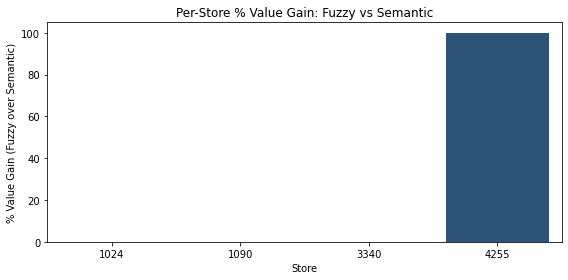

In [46]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_store_compare, x="store", y="value_pct_gain", palette="crest")
plt.title("Per-Store % Value Gain: Fuzzy vs Semantic")
plt.xlabel("Store")
plt.ylabel("% Value Gain (Fuzzy over Semantic)")
plt.tight_layout()
plt.show()


In [47]:
output_path = os.path.join(impact_folder, "waste_gain_store_comparison.csv")
df_store_compare.to_csv(output_path, index=False)
print("Saved detailed store comparison to:", output_path)


Saved detailed store comparison to: waste_simulation\waste_gain_store_comparison.csv


In [62]:
# Reload fuzzy matches
fuzzy_matches = pd.read_csv(os.path.join("matching_scored", "matching_matrix_fuzzy.csv"))
fuzzy_matches = fuzzy_matches.drop(columns=["recipe", "recipe_x", "recipe_y"], errors="ignore")

# Reload semantic matches (the correct file!)
semantic_matches = pd.read_csv(os.path.join("matching_scored", "matching_matrix_semantic.csv"))
semantic_matches = semantic_matches.drop(columns=["recipe", "recipe_x", "recipe_y"], errors="ignore")

# Load recipe metadata and rebuild row_id if needed
recipes = pd.read_csv(os.path.join("variant_exports", "recipes_with_variants.csv"))
if "row_id" not in recipes.columns:
    recipes = recipes.reset_index(drop=False).rename(columns={"index": "row_id"})

# Normalize merge keys
for df in [fuzzy_matches, semantic_matches, recipes]:
    df["row_id"] = pd.to_numeric(df["row_id"], errors="coerce").astype("Int64")
    df["ingredient"] = df["ingredient"].astype(str).str.strip().str.lower()
recipes["recipe"] = recipes["recipe"].astype(str).str.strip()

# Merge recipe names back in
fuzzy_matches = fuzzy_matches.merge(
    recipes[["row_id", "ingredient", "recipe"]],
    on=["row_id", "ingredient"],
    how="left"
)
semantic_matches = semantic_matches.merge(
    recipes[["row_id", "ingredient", "recipe"]],
    on=["row_id", "ingredient"],
    how="left"
)

# Confirm recipe column added
assert "recipe" in fuzzy_matches.columns
assert "recipe" in semantic_matches.columns
print("Merge successful. Recipe context restored to both match datasets.")


Merge successful. Recipe context restored to both match datasets.


In [64]:
# Display top 3 semantic matches
print("Top Semantic Matches:")
semantic_cols = ["product_article", "product_name", "semantic_score"]
if "product_concept" in sem_ex_sorted.columns:
    semantic_cols.insert(2, "product_concept")
display(sem_ex_sorted[semantic_cols].head(3))

# Display top 3 fuzzy matches
print("Top Fuzzy Matches:")
fuzzy_cols = ["product_article", "product_name", "fuzzy_score"]
if "product_concept" in fuzzy_ex_sorted.columns:
    fuzzy_cols.insert(2, "product_concept")
display(fuzzy_ex_sorted[fuzzy_cols].head(3))


Top Semantic Matches:


,product_article,product_name,semantic_score
52,438226,roeryoghurt,0.0
53,438226,roeryoghurt,0.0
76,438226,roeryoghurt,0.0


Top Fuzzy Matches:


,product_article,product_name,product_concept,fuzzy_score
12,105755,Kwark aardbei,yogurt,100.0
13,438226,Roeryoghurt,yogurt,100.0


In [65]:
# Store-level inspection: full fuzzy vs semantic breakdown
store_filter = 4255
recipe_filter = "Greek Yogurt & Honey"
ingredient_filter = "yogurt"

# Extract context for this case
sem_ex = semantic_matches.query(
    "store == @store_filter and recipe == @recipe_filter and ingredient == @ingredient_filter"
).sort_values("semantic_score", ascending=False)

fuzzy_ex = fuzzy_matches.query(
    "store == @store_filter and recipe == @recipe_filter and ingredient == @ingredient_filter"
).sort_values("fuzzy_score", ascending=False)

# Display full semantic context
print(f"\nTop Semantic Matches for {ingredient_filter} in '{recipe_filter}' @ store {store_filter}:")
semantic_cols = ["product_article", "product_name", "semantic_score"]
if "product_concept" in sem_ex.columns:
    semantic_cols.insert(2, "product_concept")
display(sem_ex[semantic_cols].head(5))

# Display full fuzzy context
print(f"\nTop Fuzzy Matches for {ingredient_filter} in '{recipe_filter}' @ store {store_filter}:")
fuzzy_cols = ["product_article", "product_name", "fuzzy_score"]
if "product_concept" in fuzzy_ex.columns:
    fuzzy_cols.insert(2, "product_concept")
display(fuzzy_ex[fuzzy_cols].head(5))



Top Semantic Matches for yogurt in 'Greek Yogurt & Honey' @ store 4255:


,product_article,product_name,semantic_score
52,438226,roeryoghurt,0.0
53,438226,roeryoghurt,0.0
76,438226,roeryoghurt,0.0
75,438226,roeryoghurt,0.0
74,438226,roeryoghurt,0.0



Top Fuzzy Matches for yogurt in 'Greek Yogurt & Honey' @ store 4255:


,product_article,product_name,product_concept,fuzzy_score
12,105755,Kwark aardbei,yogurt,100.0
13,438226,Roeryoghurt,yogurt,100.0
